# Importing necessary libraries <a class="anchor" id="2"></a>



In [54]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
%matplotlib inline


from keras.models import Sequential
from keras.optimizers import Adam ,RMSprop
from keras import  backend as K
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.utils import to_categorical, plot_model
from keras.callbacks import EarlyStopping

# MNIST dataset <a class="anchor" id="3"></a>



In [55]:
# import dataset
from keras.datasets import mnist

# load dataset
(x_train, y_train),(x_test, y_test) = mnist.load_data()

# count the number of unique train labels
unique, counts = np.unique(y_train, return_counts=True)
print("Train labels: ", dict(zip(unique, counts)))

# count the number of unique test labels
unique, counts = np.unique(y_test, return_counts=True)
print("\nTest labels: ", dict(zip(unique, counts)))


Train labels:  {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}

Test labels:  {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


# Data visualization <a class="anchor" id="4"></a>



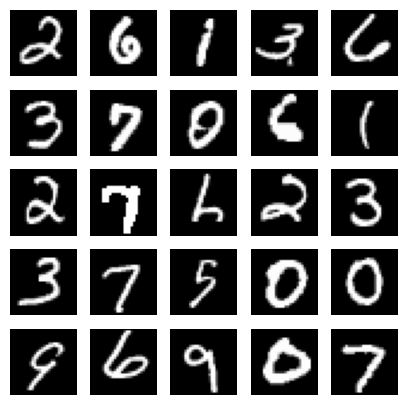

In [56]:
# sample 25 mnist digits from train dataset
indexes = np.random.randint(0, x_train.shape[0], size=25)
images = x_train[indexes]
labels = y_train[indexes]


# plot the 25 mnist digits
plt.figure(figsize=(5,5))
for i in range(len(indexes)):
    plt.subplot(5, 5, i + 1)
    image = images[i]
    plt.imshow(image, cmap='gray')
    plt.axis('off')

plt.show()
plt.savefig("mnist-samples.png")
plt.close('all')

# Designing model architecture using Keras <a class="anchor" id="5"></a>







## Compute the number of labels <a class="anchor" id="5.2"></a>


In [57]:
# compute the number of labels
num_labels = len(np.unique(y_train))

## One-Hot Encoding <a class="anchor" id="5.3"></a>

- At this point, the labels are in digits format, 0 to 9.

- This sparse scalar representation of labels is not suitable for the neural network prediction layer that outputs probabilities per class.

- A more suitable format is called a one-hot vector, a 10-dim vector with all elements 0, except for the index of the digit class.

- For example, if the label is 2, the equivalent one-hot vector is [0,0,1,0,0,0,0,0,0,0]. The first label has index 0.

- The following lines convert each label into a one-hot vector:

In [58]:
# convert to one-hot vector
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Data Preprocessing <a class="anchor" id="5.4"></a>




In [59]:
# image dimensions (assumed square)
image_size = x_train.shape[1]
input_size = image_size * image_size
input_size

784

In [60]:
# resize and normalize
x_train = np.reshape(x_train, [-1, input_size])
x_train = x_train.astype('float32') / 255
x_test = np.reshape(x_test, [-1, input_size])
x_test = x_test.astype('float32') / 255

## Setting network parameters <a class="anchor" id="5.5"></a>


In [61]:
# network parameters
batch_size = 128
hidden_units = 256
dropout = 0.45

## Designing the model architecture <a class="anchor" id="5.6"></a>



In [62]:
model = Sequential()

model.add(Dense(hidden_units, input_dim=input_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(hidden_units, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

- Since a Dense layer is a linear operation, a sequence of Dense layers can only approximate a linear function.

- The problem is that the MNIST digit classification is inherently a non-linear process. Inserting a relu activation between Dense layers will enable MLPs to model non-linear mappings.

- relu or Rectified Linear Unit (ReLU) is a simple non-linear function. It allows positive inputs to pass through unchanged while clamping everything else to zero.

## View model summary <a class="anchor" id="5.7"></a>

- Keras library provides us **summary()** method to check the model description.

In [63]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 256)               200704    
                                                                 
 batch_normalization_6 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 activation_9 (Activation)   (None, 256)               0         
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               65536     
                                                                 
 batch_normalization_7 (Bat  (None, 256)               1024      
 chNormalization)                                     

- The above listing shows the model summary of the proposed network. It requires a total of 269,322 parameters.

- This is substantial considering that we have a simple task of classifying MNIST digits. So, MLPs are not parameter efficient.

- The total number of parameters required can be computed as follows:

  - From input to Dense layer: 784 × 256 + 256 = 200,960.
  
  - From first Dense to second Dense: 256 × 256 + 256 = 65,792.
  
  - From second Dense to the output layer: 10 × 256 + 10 = 2,570.
  
  - The total is 200,690 + 65,972 + 2,570 = 269,322.

- Another way of verifying the network is by calling the **plot_model()** method as follows:

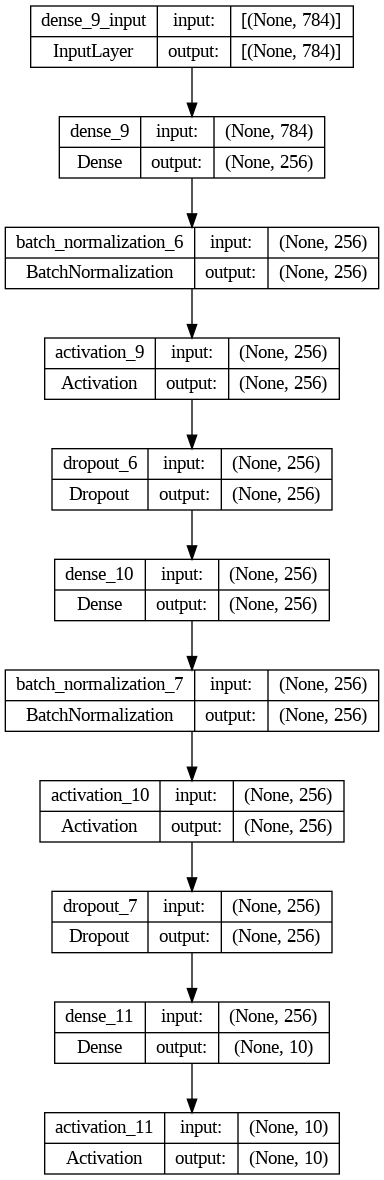

In [64]:
plot_model(model, to_file='mlp-mnist.png', show_shapes=True)

# Implement MLP model using Keras <a class="anchor" id="6"></a>




- The implementation of MLP model in Keras comprises of three steps:-

  - Compiling the model with the compile() method.
  
  - Training the model with fit() method.
  
  - Evaluating the model performance with evaluate() method.
  


## Compile the model with compile() method <a class="anchor" id="6.1"></a>




In [65]:
from keras.optimizers import SGD
sgd = SGD(
    learning_rate=0.05,
    momentum=0.9
)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Loss function (categorical_crossentropy)

- How far the predicted tensor is from the one-hot ground truth vector is called **loss**.

- In this example, we use **categorical_crossentropy** as the loss function. It is the negative of the sum of the product of the target and the logarithm of the prediction.

- There are other loss functions in Keras, such as mean_absolute_error and binary_crossentropy. The choice of the loss function is not arbitrary but should be a criterion that the model is learning.

- For classification by category, categorical_crossentropy or mean_squared_error is a good choice after the softmax activation layer. The binary_crossentropy loss function is normally used after the sigmoid activation layer while mean_squared_error is an option for tanh output.

### Optimization (optimizer adam)

- With optimization, the objective is to minimize the loss function. The idea is that if the loss is reduced to an acceptable level, the model has indirectly learned the function mapping input to output.

- In Keras, there are several choices for optimizers. The most commonly used optimizers are; **Stochastic Gradient Descent (SGD)**, **Adaptive Moments (Adam)** and **Root Mean Squared Propagation (RMSprop)**.

- Each optimizer features tunable parameters like learning rate, momentum, and decay.

- Adam and RMSprop are variations of SGD with adaptive learning rates. In the proposed classifier network, Adam is used since it has the highest test accuracy.

### Metrics (accuracy)

- Performance metrics are used to determine if a model has learned the underlying data distribution. The default metric in Keras is loss.

- During training, validation, and testing, other metrics such as **accuracy** can also be included.

- **Accuracy** is the percent, or fraction, of correct predictions based on ground truth.

## Train the model with fit() method <a class="anchor" id="6.2"></a>

In [66]:
usualCallback = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5)
history = model.fit(x_train, y_train, epochs=100, batch_size=batch_size, validation_split=0.1, shuffle=True, callbacks=[usualCallback])

Epoch 1/100
422/422 [==============================] - 4s 6ms/step - loss: 0.4532 - accuracy: 0.8586 - val_loss: 0.1347 - val_accuracy: 0.9612
Epoch 2/100
422/422 [==============================] - 2s 5ms/step - loss: 0.2291 - accuracy: 0.9299 - val_loss: 0.0978 - val_accuracy: 0.9703
Epoch 3/100
422/422 [==============================] - 3s 7ms/step - loss: 0.1793 - accuracy: 0.9440 - val_loss: 0.0880 - val_accuracy: 0.9750
Epoch 4/100
422/422 [==============================] - 2s 5ms/step - loss: 0.1533 - accuracy: 0.9529 - val_loss: 0.0768 - val_accuracy: 0.9775
Epoch 5/100
422/422 [==============================] - 2s 5ms/step - loss: 0.1357 - accuracy: 0.9575 - val_loss: 0.0759 - val_accuracy: 0.9767
Epoch 6/100
422/422 [==============================] - 2s 5ms/step - loss: 0.1260 - accuracy: 0.9611 - val_loss: 0.0703 - val_accuracy: 0.9778
Epoch 7/100
422/422 [==============================] - 2s 5ms/step - loss: 0.1112 - accuracy: 0.9651 - val_loss: 0.0678 - val_accuracy: 0.9800

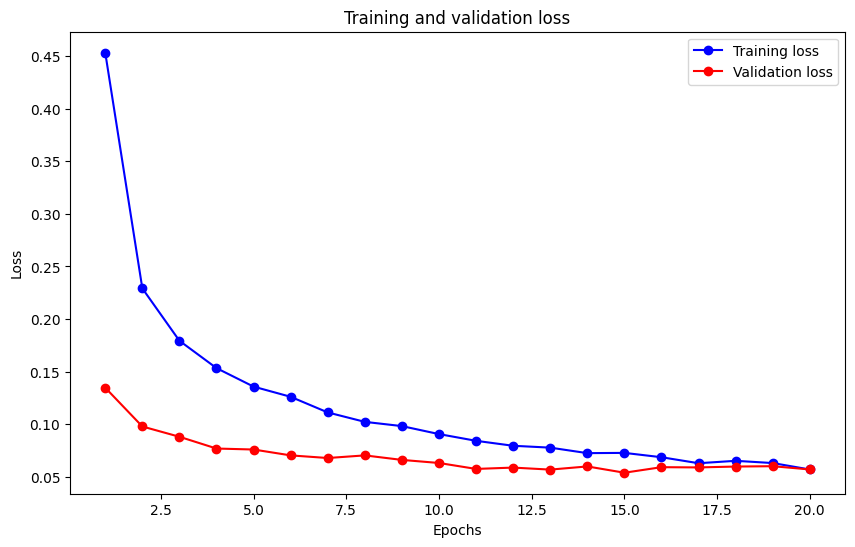

In [67]:
import matplotlib.pyplot as plt

# Extract the loss and validation loss from the history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss and validation loss
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluating model performance with evaluate() method <a class="anchor" id="6.3"></a>

In [68]:
loss, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

79/79 [==============================] - 0s 4ms/step - loss: 0.0634 - accuracy: 0.9811

Test accuracy: 98.1%


# Overfitting and Regularization <a class="anchor" id="7"></a>



- A neural network has the property to memorize the characteristics of training data. This is called **overfitting**.

- In such a case, the network fails to generalize when subject to the test data.

- To avoid this tendency, the model uses a regularizing layer or function. A commonly used regularizing layer is referred to as a **Dropout layer**.

- Given a dropout rate (dropout=0.45), the **Dropout layer** randomly removes the fraction of units from participating in the next layer. For example, if the first layer has 256 units, after dropout=0.45 is applied, only (1 - 0.45) * 256 units = 140 units from layer 1 participate in layer 2.

- The Dropout layer makes neural networks robust to unforeseen input data because the network is trained to predict correctly, even if some units are missing.

- The dropout is not used in the output layer and it is only active during training. Moreover, dropout is not present during prediction.
